Here we calculate the optical path length difference in a model potential of the wire to obtain the phase change in the electron wave. 

In [1]:
import sympy as sp
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, e, m_e, h
import numba
from numbalsoda import dop853, lsoda, lsoda_sig
from numba import cfunc
%matplotlib widget


Again set up constants and sympy symbols, and define the equation in sympy, and make a lambda function out of it.

In [2]:
#Use scipy's constants
e = e #-1.60217662e-19 #unit C
m = m_e #9.10938356e-31 #unit kg
h_planck = h #6.62607015e-34 #unit J . s 
c_l = c #2.99792458e8 #unit m/s
eps_0_val = epsilon_0 #8.85418782e-12 #permittivity unit F/m
eps = abs(e)/(2*m*c_l**2) #eps as defined in Hawkes, different from the permittivity of free space. 

sp.init_printing()

x, y, z = sp.symbols('x y z')
V = -6
r = 0.125e-6
R = 1e-3

phi_biprism = V/(2*sp.log(((np.pi*r)/(4*R))))*(
            sp.log((sp.cosh((np.pi*(z))/(2*R))-sp.cos((np.pi*x)/(2*R)))/
                    (sp.cosh((np.pi*(z))/(2*R))+sp.cos((np.pi*x)/(2*R)))))

phi_biprism = V*(sp.log((x*x+(z)**2)/(R**2)))/(2*sp.log(r/R))


display(phi_biprism)

In [3]:
phi_biprism_lambda = sp.lambdify([x, y, z], phi_biprism, 'numpy')

Calculate the E-Field so we can plot it. 

In [4]:
Ex = -1*phi_biprism.diff(x)
Ey = -1*phi_biprism.diff(y)
Ez = -1*phi_biprism.diff(z)

In [5]:
E_lambda = sp.lambdify([x, y, z], [Ex, Ey, Ez], 'numpy')


Plot the view of the electron as it moves towards the potential in the x-y plane. 

Text(0, 0.5, 'y (m)')

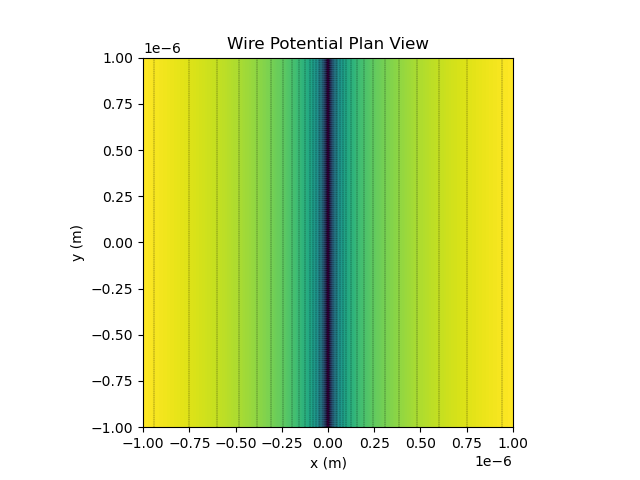

In [6]:
z_ = np.linspace(-1, 1, 1000)
plan_figure, plan_ax = plt.subplots()

scale = 1000e-9
x_line, xstep = np.linspace(-scale, scale, 300, retstep = True)
y_line, ystep = np.linspace(-scale, scale, 300, retstep = True)
x_grid, y_grid = np.meshgrid(x_line, y_line)
z_grid = 0*np.ones(x_grid.shape)

potential_image = phi_biprism_lambda(x_grid, y_grid, 0)
plan_ax.imshow(potential_image, extent=[-scale, scale, -scale, scale])
plan_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent=[-scale, scale, -scale, scale], origin = 'upper')
plan_ax.set_title('Wire Potential Plan View')
plan_ax.set_xlabel('x (m)')
plan_ax.set_ylabel('y (m)')


Plot a side view of the potential 

Text(0, 0.5, 'y (m)')

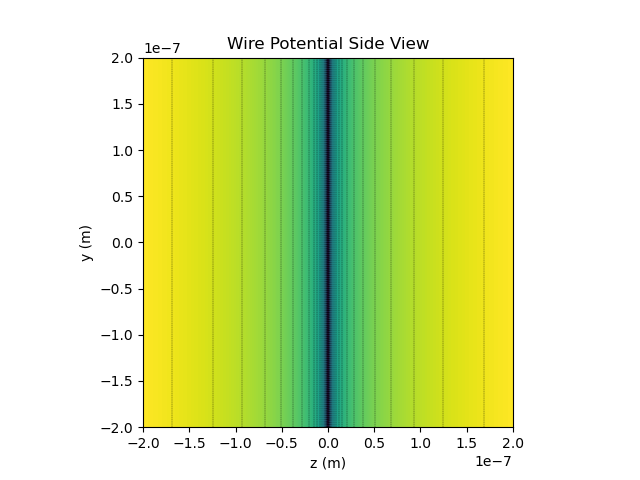

In [7]:
zy_figure, zy_ax = plt.subplots()
z_line, zstep = np.linspace(-200e-9, 200e-9, 1000, retstep = True)
y_line, ystep = np.linspace(-200e-9, 200e-9, 1000, retstep = True)
z_grid, y_grid = np.meshgrid(y_line, z_line)
x_grid = 0*np.ones(y_grid.shape)
potential_image = phi_biprism_lambda(x_grid, y_grid, z_grid)
zy_ax.imshow(potential_image, extent=[-200e-9, 200e-9, -200e-9, 200e-9], origin = 'upper')
zy_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent = [-200e-9, 200e-9, -200e-9, 200e-9], origin = 'upper')
zy_ax.set_title('Wire Potential Side View')
zy_ax.set_xlabel('z (m)')
zy_ax.set_ylabel('y (m)')


Plot the E-Fields

Text(0, 0.5, 'x (m)')

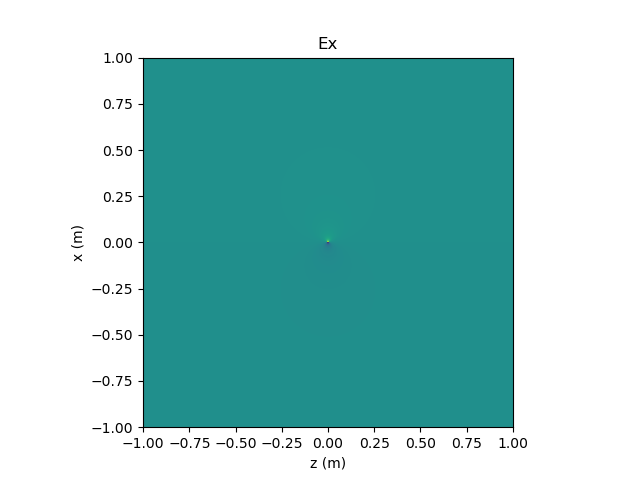

In [8]:
Ex_figure, Ex_ax = plt.subplots()
Ez_line, Ezstep = np.linspace(-1, 1, 500, retstep = True)
Ex_line, Exstep = np.linspace(-1, 1, 500, retstep = True)
Ez_grid, Ex_grid = np.meshgrid(Ex_line, Ez_line)
Ey_grid = 0.1*np.ones(Ex_grid.shape)
efield_image = E_lambda(Ex_grid, Ey_grid, Ez_grid)[0]
Ex_ax.imshow(efield_image, extent=[-1, 1, -1, 1], origin = 'upper')
Ex_ax.set_title('Ex')
Ex_ax.set_xlabel('z (m)')
Ex_ax.set_ylabel('x (m)')

Text(0, 0.5, 'x (m)')

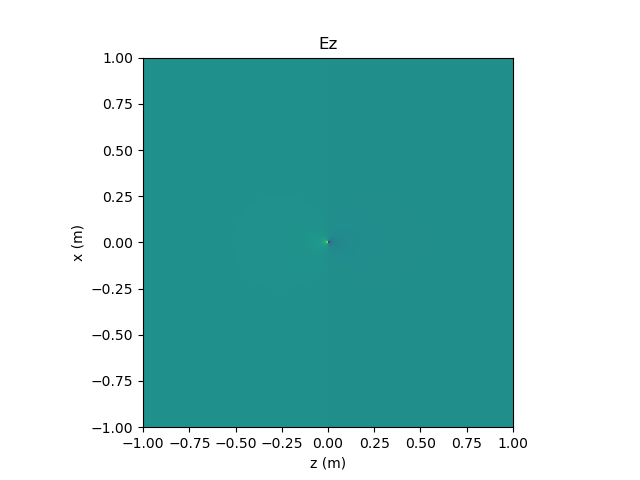

In [9]:
Ez_figure, Ez_ax = plt.subplots()
Ez_line, Ezstep = np.linspace(-1, 1, 500, retstep = True)
Ex_line, Exstep = np.linspace(-1, 1, 500, retstep = True)
Ez_grid, Ex_grid = np.meshgrid(Ex_line, Ez_line)
Ey_grid = 0.1*np.ones(Ex_grid.shape)
efield_image = E_lambda(Ex_grid, Ey_grid, Ez_grid)[2]
Ez_ax.imshow(efield_image, extent=[-1, 1, -1, 1], origin = 'upper')
Ez_ax.set_title('Ez')
Ez_ax.set_xlabel('z (m)')
Ez_ax.set_ylabel('x (m)')


And make our relativistic potential function that we need to put into our ODE solver

In [10]:
def make_potential_and_efield(phi, phi_0, x, y, z, eps):
    
    phi_hat = (phi_0-phi)*(1+eps*(phi_0-phi))
    
    #Get E field function. Notice there is no negative sign, as the way hawkes uses phi_hat, there is no minus before it (Equation 3.22).
    dphi_hat_wires_electron_dx = phi_hat.diff(x)
    dphi_hat_wires_electron_dy = phi_hat.diff(y)
    dphi_hat_wires_electron_dz = phi_hat.diff(z)
    phi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], phi_hat, 'numpy'), nopython = True)
    dphi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], [dphi_hat_wires_electron_dx, dphi_hat_wires_electron_dy, dphi_hat_wires_electron_dz], 'numpy'), nopython = True)
    
    return phi_hat_wires_electron_lambda, dphi_hat_wires_electron_lambda

In [11]:
phi_0 = 0.8e5 #unit V #2e5
phi_hat_lambda, dphi_hat_lambda = make_potential_and_efield(phi_biprism, phi_0, x, y, z, eps)

In [12]:
@numba.jit(nopython = True, cache=True)
def trajectory_equation_of_motion(z, x, phi_hat_lambda, dphi_hat_lambda, phi_hat_0):
    
    p = np.sqrt(1+x[1]**2+x[3]**2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield
    return [x[1], (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z), x[3], (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z), (phi_hat/phi_hat_0)**(1/2)*p] #evaluate the velocities and accelerations, [vx, ax, vy, ay]

@cfunc(lsoda_sig)
def trajectory_equation_of_motion_numba(z, x, dx, phi_hat_0):
    
    p = (1+x[1]**2+x[3]**2)**(1/2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield
    dx[0] = x[1]
    dx[1] = (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z)
    dx[2] = x[3]
    dx[3] = (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z)
    dx[4] = (phi_hat/phi_hat_0[0])**(1/2)*p

Integration parameters for scipy and other housekeeping.

In [13]:
x0 = np.array([0, 1e-4, 0, 0, 0]) #x, x', y, y', opl # we are including the optical path length calculation as updates in the model. 
z0 = -0.05 #Initial z plane
zF = 0.06 #Final z plane

#Need the potential at the beginning for the optical path length calculation.
phi_hat_lambda_0 = phi_hat_lambda(x0[0], x0[2], z0)

#We need to assign the equation for numbalsoda to an address in memory.
rhs = trajectory_equation_of_motion_numba
funcptr = rhs.address

from scipy.integrate import solve_ivp

params = {'max_step': np.inf,
          'rtol': 1e-13,
          'atol': 1e-20,
          }


Solve the electron equation of motion with scipy first.

In [14]:
sol = solve_ivp(trajectory_equation_of_motion, (z0, zF), x0,
                method='LSODA', **params,
                args=(phi_hat_lambda, dphi_hat_lambda, phi_hat_lambda_0), dense_output=True)

Obtain results and print the optical path length as a brief check.

26342432241.583538


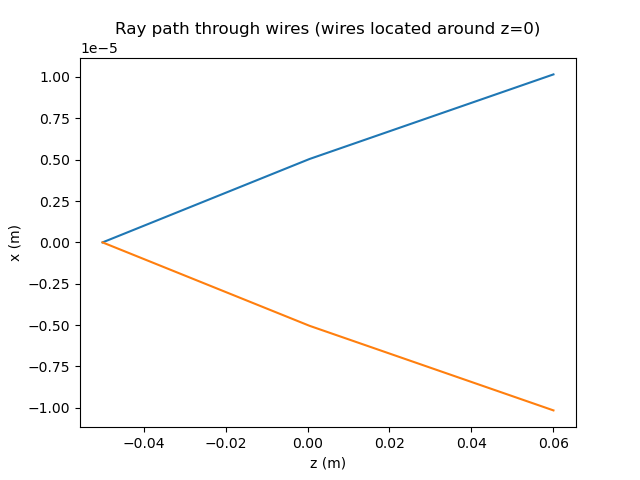

In [15]:
z_orig = sol.t
x_orig = sol.y

z_precise = np.linspace(z0, zF, int(1e7))
x_precise = sol.sol(z_precise)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

x0 = np.array([0, -1e-4, 0, 0, 0])
sol = solve_ivp(trajectory_equation_of_motion, (z0, zF), x0,
                method='LSODA', **params,
                args=(phi_hat_lambda, dphi_hat_lambda, phi_hat_lambda_0), dense_output=True)

plt.plot(sol.t, sol.y[0])

wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)

print(x_orig[4][-1]/wavelengths[0])

Check that the methods with numbalsoda produce the same results. 

In [16]:
sol_numba_dop, success = dop853(funcptr, x0, t_eval = np.array([-1.,  1.]), data = np.array([phi_hat_lambda_0]), rtol = 1.0e-13, atol = 1.0e-20)
sol_numba_lsoda, success = lsoda(funcptr, x0, t_eval = np.array([-1.,  1.]), data = np.array([phi_hat_lambda_0]), rtol = 1.0e-13, atol = 1.0e-20)

In [17]:
print(sol_numba_dop[-1][-1]/wavelengths[0])
print(sol_numba_lsoda[-1][-1]/wavelengths[0])

478947104939.01056
478947104939.0139


Note that these numbers above represent the fractions of a wavelength that fit into the path - the values after the decimal place tell us the phase of the wavefront. Results are similar, but not exact. About 2 decimal places is probably trustworthy. This gives us a resolution that we can decompose our phase into - about 100 units of accuracy for the phase (2 decimal places). 


Plot path of ray in z-y (ray should not see any deflection) and z-x plane (ray should be deflected significantly)

In [18]:
print('X positional deflection (scipy) (m):', sol.y[0][-1])
print('Y positional deflection (scipy) (m):', sol.y[2][-1])

X positional deflection (scipy) (m): -1.0156465330519121e-05
Y positional deflection (scipy) (m): 0.0



Plot the "wavelength" of the electron as it moves through the potential.

4.175792596274897e-12 4.175617062255465e-12


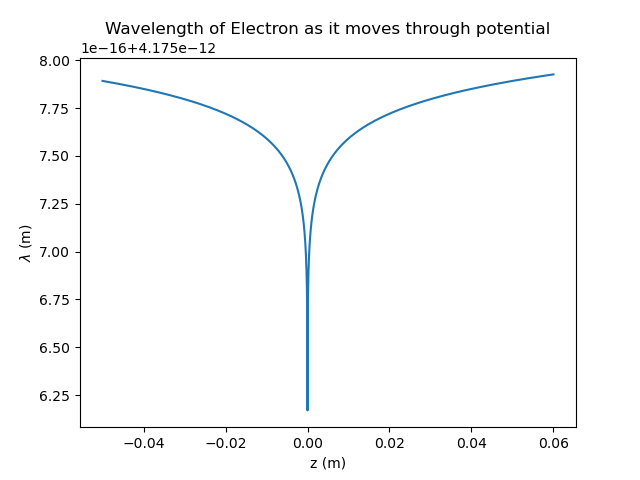

In [19]:
plt.figure()
plt.title('Wavelength of Electron as it moves through potential')
plt.xlabel('z (m)')
plt.ylabel('$\lambda$ (m)')
plt.plot(z_precise, wavelengths)
print(max(wavelengths), min(wavelengths))


Now we need to perform the optical path length calculation. We can do this multiple ways, and we need to check the results of each.

In [20]:
def opl(x, y, z, x_prime, y_prime, phi_hat_lambda, wavelengths):
    
    phi_hat_lambda0 = phi_hat_lambda(x[0], y[0], z[0]) #get the potential at the start
    dx, dy, dz = np.diff(x), np.diff(y), np.diff(z) #get the path differences between each coordinate
    ds = np.sqrt(dx**2+dy**2+dz**2) #calculate the little ds values (distances travelled) between each integration step

    rho = np.sqrt(1+x_prime[:-1]**2+y_prime[:-1]**2)
    
    #Get the OPL with 3 different method numerically. 
    opl_ds = np.sum(np.sqrt(phi_hat_lambda(x[:-1], y[:-1], z[:-1])/phi_hat_lambda0)*ds)
    opl_dz = np.sum(np.sqrt(phi_hat_lambda(x[:-1], y[:-1], z[:-1])/phi_hat_lambda0)*rho*dz)
    opl_length_over_wavelength = np.sum(ds/wavelengths[:-1])*wavelengths[0]
    
    return opl_ds, opl_dz, opl_length_over_wavelength

Get the wavelengths from the steps that the integrator took actually (_orig symbol indicates I am using the positions that the integrator solved for)

In [21]:
wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_orig[0], x_orig[2], z_orig))**(1/2)
opl_from_ode = x_orig[4][-1]
opl_ds, opl_dz, opl_length_over_wavelength = opl(x_orig[0], x_orig[2], z_orig, x_orig[1], x_orig[3], phi_hat_lambda, wavelengths)

Lets check the Optical path length results for each method. What we want to see here is that the fraction at the end of the calculation for the number of wavelengths inside the path is the same - as that fraction is the essentially the phase of the wavefront. 

In [22]:
print('OPL ds =' , opl_ds)
print('OPL dz =' , opl_dz)
print('OPL length/wavelength =' , opl_length_over_wavelength)
print('OPL from ODE =' , x_orig[4][-1], '\n')

OPL ds = 0.11000044470623754
OPL dz = 0.1100004447062381
OPL length/wavelength = 0.11000044470623759
OPL from ODE = 0.11000044376095985 



In [23]:
print('Num Wavelengths - OPL ds =' , opl_ds/wavelengths[0])
print('Num Wavelengths - OPL dz =' , opl_dz/wavelengths[0])
print('Num Wavelengths - OPL length/wavelength =' , opl_length_over_wavelength/wavelengths[0])
print('Num Wavelengths - OPL from ODE = ' , x_orig[4][-1]/wavelengths[0], '\n')

Num Wavelengths - OPL ds = 26342432467.954567
Num Wavelengths - OPL dz = 26342432467.9547
Num Wavelengths - OPL length/wavelength = 26342432467.954575
Num Wavelengths - OPL from ODE =  26342432241.583538 



In [24]:
wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)
opl_ds, opl_dz, opl_length_over_wavelength = opl(x_precise[0], x_precise[2], z_precise, x_precise[1], x_precise[3], phi_hat_lambda, wavelengths)

In [25]:
print('OPL ds (precise) =' , opl_ds)
print('OPL dz (precise) =' , opl_dz)
print('OPL length/wavelength (precise) =' , opl_length_over_wavelength, '\n')
print('OPL from ODE =' , x_orig[4][-1], '\n')

OPL ds (precise) = 0.11000044376096386
OPL dz (precise) = 0.11000044376096386
OPL length/wavelength (precise) = 0.11000044376096381 

OPL from ODE = 0.11000044376095985 



In [26]:
print('Num Wavelengths - OPL ds (precise) =' , opl_ds/wavelengths[0])
print('Num Wavelengths - OPL dz (precise) = ' , opl_dz/wavelengths[0])
print('Num Wavelengths - OPL length/wavelength (precise) = ' , opl_length_over_wavelength/wavelengths[0])
print('Num Wavelengths - OPL from ODE = ' , x_orig[4][-1]/wavelengths[0], '\n')

Num Wavelengths - OPL ds (precise) = 26342432241.5845
Num Wavelengths - OPL dz (precise) =  26342432241.5845
Num Wavelengths - OPL length/wavelength (precise) =  26342432241.584484
Num Wavelengths - OPL from ODE =  26342432241.583538 



It's hard to discern the results. Using each of the numerical methods, we can end up with a different phase at the end. If we precisely evaluate our electron position at many positions, our result approaches the phase found when performing the calculation in the ODE (with results of about 0.46). I think still the method of evaluating the phase as the ODE solves the path is probably the most accurate, but I do not know for certain. 

It's hard to know if we can trust our calculation of the phase to more than 1 or 2 decimal place, but we don't have much of a choice. I can't really eek out any more precision without doing a lot more thinking and rearranging the equations to be non dimensionalised I think (even then I don't know if it would work, the difference in scales is the challenge here). I think we can move on for now, and actually see if we can calculate a wavefront image with a parallelised code. I will need to think of a way to validate this method later. 

Below is just some code for me to check how many rays I should trace so that I can evenly parallelise with 12 threads on my CPU. 

Do the calculation for around 1 million rays, which takes a couple of minutes to generate an image on my PC. 

In [27]:
macro_block_size = 24
n_threads = 12
scale = 1
n = (n_threads*macro_block_size*scale)**2
print(n)
num_along_dim = int(np.sqrt(n))
print(num_along_dim)

82944
288


[-1.00000000e-05 -9.93706294e-06 -9.87412587e-06 -9.81118881e-06
 -9.74825175e-06 -9.68531469e-06 -9.62237762e-06 -9.55944056e-06
 -9.49650350e-06 -9.43356643e-06 -9.37062937e-06 -9.30769231e-06
 -9.24475524e-06 -9.18181818e-06 -9.11888112e-06 -9.05594406e-06
 -8.99300699e-06 -8.93006993e-06 -8.86713287e-06 -8.80419580e-06
 -8.74125874e-06 -8.67832168e-06 -8.61538462e-06 -8.55244755e-06
 -8.48951049e-06 -8.42657343e-06 -8.36363636e-06 -8.30069930e-06
 -8.23776224e-06 -8.17482517e-06 -8.11188811e-06 -8.04895105e-06
 -7.98601399e-06 -7.92307692e-06 -7.86013986e-06 -7.79720280e-06
 -7.73426573e-06 -7.67132867e-06 -7.60839161e-06 -7.54545455e-06
 -7.48251748e-06 -7.41958042e-06 -7.35664336e-06 -7.29370629e-06
 -7.23076923e-06 -7.16783217e-06 -7.10489510e-06 -7.04195804e-06
 -6.97902098e-06 -6.91608392e-06 -6.85314685e-06 -6.79020979e-06
 -6.72727273e-06 -6.66433566e-06 -6.60139860e-06 -6.53846154e-06
 -6.47552448e-06 -6.41258741e-06 -6.34965035e-06 -6.28671329e-06
 -6.22377622e-06 -6.16083

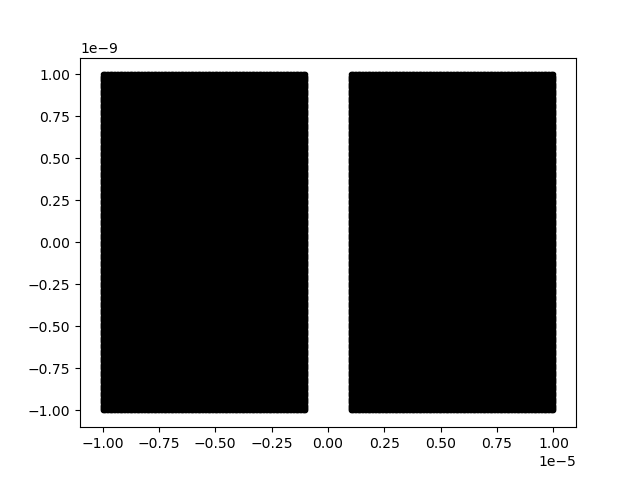

In [39]:
#x0 = np.concatenate((np.linspace(-2e-4, -2e-5, num_along_dim//2, dtype = np.float64, endpoint=True), np.linspace(2e-5, 2e-4, num_along_dim//2, dtype = np.float64, endpoint=True)))
#y0 = np.linspace(-1e-5, 1e-5, num_along_dim, dtype = np.float64, endpoint=True)
#x0 = np.linspace(-1e-4, 1e-4, num_along_dim, dtype = np.float64, endpoint=True)
#y0 = np.linspace(-1e-4, 1e-4, num_along_dim, dtype = np.float64, endpoint=True)

x0 = np.concatenate((np.linspace(-1e-5, -1e-6, num_along_dim//2, dtype = np.float64, endpoint=True), np.linspace(1e-6, 1e-5, num_along_dim//2, dtype = np.float64, endpoint=True)))
y0 = np.linspace(0-1e-9, 0+1e-9, num_along_dim, dtype = np.float64, endpoint=True)

grid = np.array(np.meshgrid(x0, y0))
pos_0 = grid.reshape(2, n).T
print(x0)
print(y0)

plt.figure()
plt.plot(pos_0[:, 0], pos_0[:, 1], '.k')

Evaluate the answer at 1m after the wire. At 1m we are at least we are sure that the energy of each electron is back to where it started.

In [40]:
z_eval = np.array([-0.10, 0.0, 0.06])

Perform parallelised ray tracing. 

In [41]:
from numba_progress import ProgressBar

@numba.njit(parallel=True)
def main(n, pos_0, phi_hat_lambda_0, n_threads, macro_block_size, progress_proxy):
    
    x_out = np.empty((n,len(z_eval)), np.float64)
    y_out = np.empty((n,len(z_eval)), np.float64)
    opl_out = np.empty((n,len(z_eval)), np.float64)
    
    thread_block_size = int(n/n_threads)
    macro_blocks = int(thread_block_size/macro_block_size)
    
    for thread in numba.prange(n_threads):
        thread_idx = thread*thread_block_size
        
        for macro_block in range(macro_blocks):
                #get starting index for the block of rays of each macroblock in a thread.
                macro_block_idx = macro_block*macro_block_size
                
                #combine the starting index of the thread and macroblock
                idx_start = thread_idx + macro_block_idx
                
                for j in range(macro_block_size):
                    u0 = np.empty((5,), np.float64)
                    
                    u0[0] = 0.
                    u0[1] = pos_0[idx_start+j, 0]
                    u0[2] = 0.
                    u0[3] = pos_0[idx_start+j, 1]
                    u0[4] = 0.
                    
                    usol, success = lsoda(funcptr, u0, z_eval, data = phi_hat_lambda_0, rtol = 1.0e-13, atol = 1.0e-20)
                    
                    x_out[idx_start+j] = usol[:,0]
                    y_out[idx_start+j] = usol[:,2]
                    opl_out[idx_start+j] = usol[:,4]
                    
                    progress_proxy.update(1)
            
    return x_out, y_out, opl_out

with ProgressBar(total=n) as progress:
    x_out, y_out, opl_out = main(n, pos_0, np.array([phi_hat_lambda_0]), n_threads, macro_block_size, progress)
    


  0%|          | 0/82944 [00:00<?, ?it/s]

(248832,)
(248832,)
(248832,)


C:\Users\User\AppData\Local\Temp\ipykernel_1237500\3246998305.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Text(0.5, 0.5, 'y (m)')

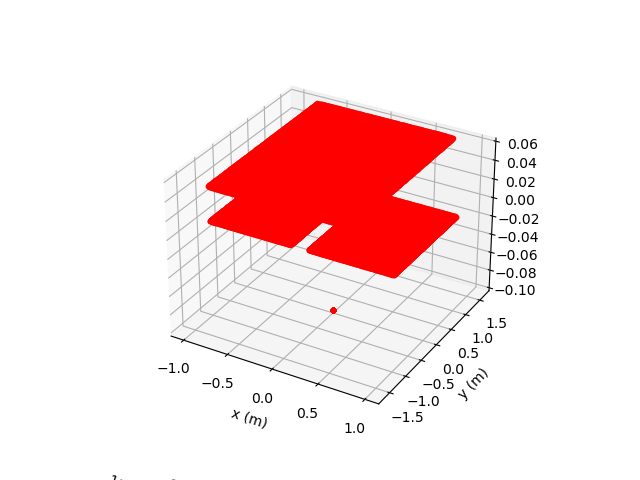

In [42]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')

def get_scale(x_out, y_out):
    x_left = np.argmin(x_out)
    x_right = np.argmax(x_out)
    y_bottom = np.argmin(y_out)
    y_top = np.argmax(y_out)
    
    return x_out[x_left], x_out[x_right], y_out[y_bottom], y_out[y_top]

#def plot_extent(ax, x_out, y_out, z_eval, c):
    
    #x_left, x_right, y_bottom, y_top = get_scale(x_out, y_out)
    
    #ax.plot(x_left, y_bottom, z_eval, c)
    #ax.plot(x_left, y_top, z_eval, c)
    #ax.plot(x_right, y_top, z_eval, c)
    #ax.plot(x_right, y_bottom, z_eval, c)
    #ax.plot(x_out, y_out, z_eval, c)

    
#plot_extent(ax, x_out[:, 0], y_out[:, 0], z_eval[0], '.r')
#plot_extent(ax, x_out[:, 1], y_out[:, 1], z_eval[1], '.g')

z_points = np.tile(np.array([z_eval]), n).T

print(z_points.ravel().shape)
print(x_out.ravel().shape)
print(y_out.ravel().shape)
ax.plot(x_out.ravel(), y_out.ravel(), z_points.ravel(), '.r')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
#print(y_out[:, 1])
#plot_extent(ax, x_out[:, 2], y_out[:, 2], z_eval[2], '.m')
#plot_extent(ax, x_out[:, 3], y_out[:, 3], z_eval[3], '.b')


0.0
0.06


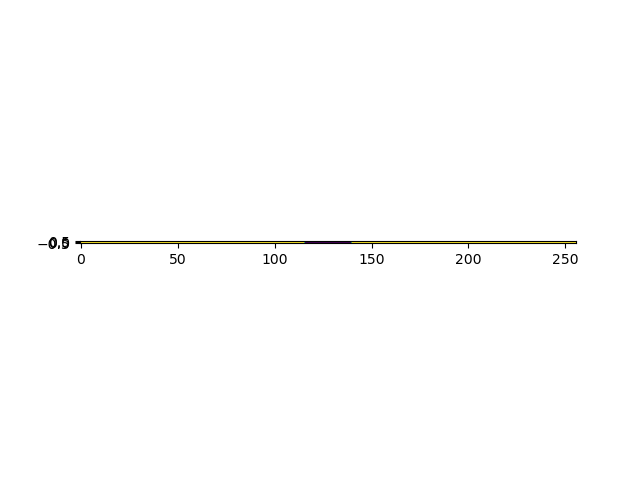

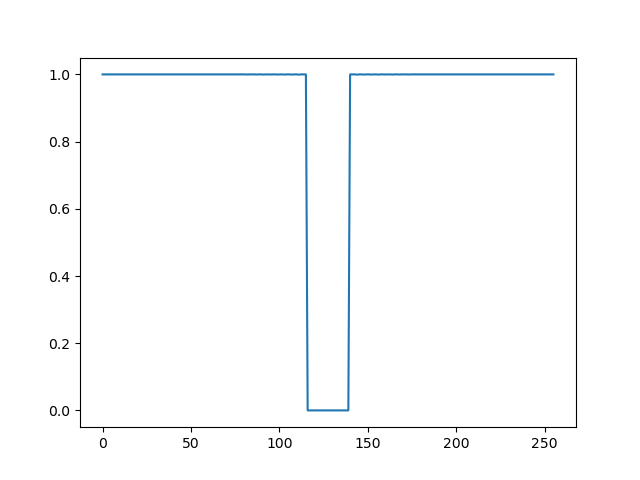

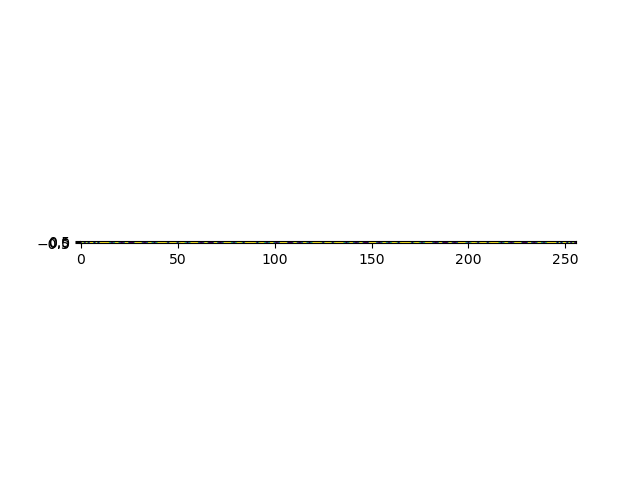

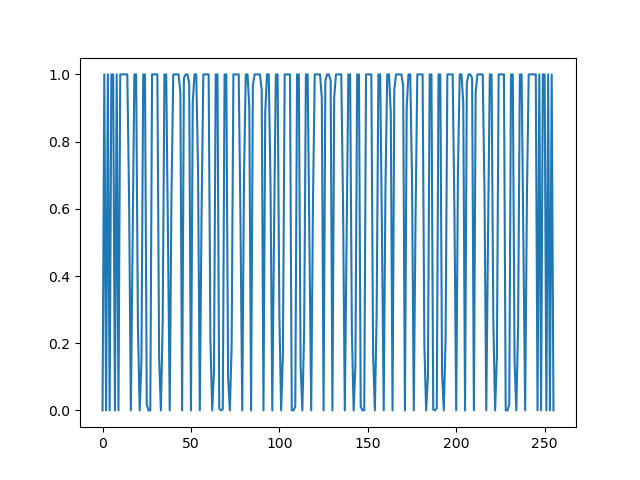

c:\Users\User\miniconda3\envs\TEMGYMAdvanced\lib\site-packages\ipympl\backend_nbagg.py:279: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.manager.handle_json(content)
c:\Users\User\miniconda3\envs\TEMGYMAdvanced\lib\site-packages\ipympl\backend_nbagg.py:279: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.manager.handle_json(content)


In [43]:
import scipy 
from collections import defaultdict

def plot_wavefunction(x_out, y_out, z_eval, phase_out, z_plane_idx, scale):

    x_left = scale[0]
    x_right = scale[1]
    y_bottom = scale[2]
    y_top = scale[3]
    
    x_edge = np.abs(x_left) + np.abs(x_right)
    y_edge = np.abs(y_bottom) + np.abs(y_top)
    
    pixels_x_edge = 256
    pixels_y_edge = int(np.ceil(y_edge/x_edge * pixels_x_edge))
    
    image = np.zeros(( pixels_x_edge, pixels_y_edge), np.complex128)

    pixel_size_x = (x_edge)/pixels_x_edge
    
    #Create a boolean mask to filter out values outside the valid range of the image plane.
    valid_mask_x = (x_out[:, z_plane_idx] > x_left) & (x_out[:, z_plane_idx] < x_right)
    valid_mask_y = (y_out[:, z_plane_idx] > y_bottom) & (y_out[:, z_plane_idx] < y_top)

    valid_mask_combined = np.logical_and(valid_mask_x, valid_mask_y)
    phase_out_valid = phase_out[valid_mask_combined]

    #Filter the coordinates to keep only the valid ones
    x_out_valid = x_out[valid_mask_combined, z_plane_idx]
    y_out_valid = y_out[valid_mask_combined, z_plane_idx]

    #Create the pixel bins
    bins_x = np.arange(x_left, x_right+pixel_size_x, pixel_size_x)
    bins_y = np.arange(y_bottom, y_top+pixel_size_x, pixel_size_x)

    #This histogram is used for testing mainly to make sure my coordinates were being counted in the right pixel.
    hist, xbins, ybins = np.histogram2d(x_out_valid, y_out_valid, bins=(bins_x, bins_y))

    x_bin_indices = np.digitize(x_out_valid, xbins) - 1
    y_bin_indices = np.digitize(y_out_valid, ybins) - 1

    bin_values = defaultdict(list)

    for i, (x_idx, y_idx) in enumerate(zip(x_bin_indices, y_bin_indices)):
        bin_values[(x_idx, y_idx)].append(phase_out_valid[i])  

    #Loop through the coordinates, find the phases of all the rays in each pixel, and calculate the interference. 
    for x, y in bin_values:
        phases = np.array(bin_values[x, y])
        image[x, y] = np.sum(np.exp(1j*phases)/len(phases))
        
    my_dpi = 300
    
    fig, ax = plt.subplots()#plt.subplots(figsize=(float(image.shape[1])/my_dpi,float(image.shape[0])/my_dpi), dpi=my_dpi)
    #fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

    #ax.set_xticks(np.linspace(x_left, x_right, 3))
    #ax.set_yticks(np.linspace(y_bottom, y_top, 3))

    plt.imsave(f'WireIntensity_z={np.round(z_eval[z_plane_idx], 4)}m.svg', (np.abs(image.T)**2), dpi = my_dpi, origin = 'lower')
    #plt.imsave(f'WireIntensity_z={np.round(z_eval[z_plane_idx], 4)}m.png', (np.abs(image.T)**2), dpi = my_dpi, origin = 'lower')
    
    #Plot the intensity image
    ax.imshow((np.abs(image.T)**2), origin = 'lower')# extent = [x_left, x_right, y_bottom, y_top])
    
    plt.figure()
    plt.plot(np.sum((np.abs(image.T)**2), axis = 0))

for z_idx, z_num in enumerate(z_eval[1:], 1):
    print(z_num)
    fractional_wavelength_out = np.round(opl_out[:, z_idx]/wavelengths[0] % 1,3)
    phase_out = np.round(fractional_wavelength_out*2*np.pi, 3)
    
    scale = get_scale(x_out[:, z_idx], y_out[:, z_idx])
    plot_wavefunction(x_out, y_out, z_eval, phase_out, z_idx, scale)
    


        